## Spectral measurements with Python and Ocean Optics USB2000+ spectrometer
## for generating LED gamma correction table

#### Author: André Maia Chagas, Katrin Franke
#### CC BY 4.0.

The script below will allow the user to read in data with USB2000+ spectrometer, plot it and calculate a gamma file to linearize the LED output.

The spectrometer measurements rely on the open source library written by Andreas Pohlmann https://github.com/ap--.
The library is a wrapper for the C++ library written by Ocean Optics.

The installation instructions for the library and setup tips are here: https://github.com/ap--/python-seabreeze
Documentation is here: https://github.com/ap--/python-seabreeze/blob/master/docs/DOCUMENTATION.md

In [1]:
# import seabreeze (use 'pyseabreeze')
import seabreeze.spectrometers as sb

import os
import numpy as np
import matplotlib.pyplot as plt

# set graphics to be plotted in the notebook
%matplotlib inline 

# for fitting gaussian to uv spectra
from scipy.optimize import curve_fit

#### Import calibration file sent by ocean optics
It contains for each wavelength the correspondent µJ/count correlation and it will be used to calibrate the readings from the spectrometer

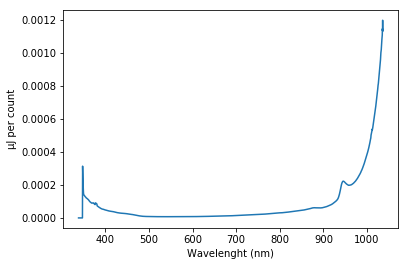

In [2]:
filePath = "C://Users//Eulerlab//Documents//Jupyter_notebooks//spectrometer//spectrometer_cal_20171101//"
filename = "USB2+F02461_20171108_CC.Irradcal" 

# open file
with open(filePath+filename, "r") as dummie:
    #read complete file and remove "\n"
    parsed = dummie.read().splitlines()

# parsed.index("[uJoule/count]")
#clean up list to get only the wavelengths and their values
parsed = parsed[parsed.index("[uJoule/count]")+1:]

# now split wavelengths and readout values
waves  = list()
values = list()
for item in parsed:
    waves.append(item[0:item.index("\t")])
    values.append(item[item.index("\t")+1:])

calib_values = np.array(values,dtype=float)
wavelengths  = np.array(waves,dtype=float)

plt.plot(wavelengths, calib_values)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("µJ per count")

#### Set the device

In [3]:
# set by serial number
spec = sb.Spectrometer.from_serial_number("USB2+F02461")

#### Set integration time in microseconds (change if output is saturated)

In [4]:
int_time_s = 1.0 # will be used to obtain µJ/s
int_time_ms = 1000*1000*(int_time_s) # in micro s
spec.integration_time_micros(int_time_ms)

#### Set stimulus parameters

In [5]:
trials_spectra = 5
step_size = 5
n_steps = int((255/step_size)+1)
contrasts = np.arange(0., step_size*n_steps, step_size)

#### Measure beackground spectrum to subtract from green LED measurement

10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% 

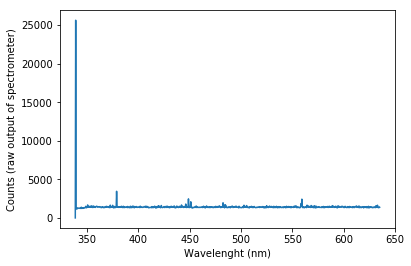

In [23]:
trials_baseline = 10 # specifies number of measurements for averaging
spec.trigger_mode(0) # spectrometer does not wait for a trigger
baseline = list()
for iT in range(trials_baseline):
    wavelengths, intensities = spec.spectrum()
    baseline.append(intensities)
    print(str(((iT+1)/trials_baseline)*100) + "% ", end='')
baseline_average = np.mean(baseline,axis=0)
plt.plot(wavelengths[0:800],baseline_average[0:800])
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Measure spectra for green calibration stimulus

In [24]:
current_spectra = list()
spectra_green = list()

for iS in range (int(n_steps)):
    for iT in range(trials_spectra):
        spec.trigger_mode(1)
        wavelengths, intensities = spec.spectrum()
        current_spectrum = intensities - baseline_average
        current_spectra.append(current_spectrum)
    average_spectrum = np.mean(current_spectra, axis=0)
    spectra_green.append(average_spectrum)
    print(str(round(((iS+1)/n_steps)*100)) + "% ", end='')

2% 4% 6% 8% 10% 12% 13% 15% 17% 19% 21% 23% 25% 27% 29% 31% 33% 35% 37% 38% 40% 42% 44% 46% 48% 50% 52% 54% 56% 58% 60% 62% 63% 65% 67% 69% 71% 73% 75% 77% 79% 81% 83% 85% 87% 88% 90% 92% 94% 96% 98% 100% 

In [8]:
spectra_uv = spectra_green

#### Measure beackground spectrum to subtract from UV LED measurement

10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% 

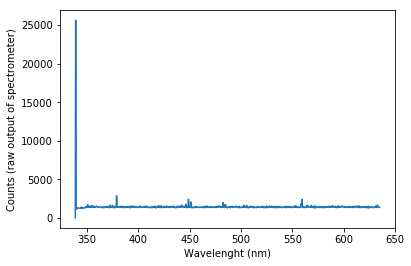

In [55]:
trials_baseline = 10 # specifies number of measurements for averaging
spec.trigger_mode(0) # spectrometer does not wait for a trigger
baseline = list()
for iT in range(trials_baseline):
    wavelengths, intensities = spec.spectrum()
    baseline.append(intensities)
    print(str(((iT+1)/trials_baseline)*100) + "% ", end='')
baseline_average = np.mean(baseline,axis=0)
plt.plot(wavelengths[0:800],baseline_average[0:800])
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Measure spectra for UV calibration stimulus

In [56]:
current_spectra = list()
spectra_uv = list()

for iS in range (int(n_steps)):
    for iT in range(trials_spectra):
        spec.trigger_mode(1)
        wavelengths, intensities = spec.spectrum()
        current_spectrum = intensities - baseline_average
        current_spectra.append(current_spectrum)
    average_spectrum = np.mean(current_spectra, axis=0)
    spectra_uv.append(average_spectrum)
    print(str(round(((iS+1)/n_steps)*100)) + "% ", end='')

2% 4% 6% 8% 10% 12% 13% 15% 17% 19% 21% 23% 25% 27% 29% 31% 33% 35% 37% 38% 40% 42% 44% 46% 48% 50% 52% 54% 56% 58% 60% 62% 63% 65% 67% 69% 71% 73% 75% 77% 79% 81% 83% 85% 87% 88% 90% 92% 94% 96% 98% 100% 

#### Transform output of spectra into µW and get intensities vs contrast curve (UV LED)
Spectra measured for UV LED are more noisy than for the green LED. Also, the raw output needs to be multiplied with the calibration file, which has higher values for the UV range. Therefore, we cant use the raw spectra because of very bas S/N. Spectra are fit with a gaussian and the gaussian fit is used for transforming the values into µW.

In [9]:
start_points_uv = 0
end_points_uv = 200
led_peak_uv = 387

led_width = 10
step_size = 5

spectra_uv_µw = list()
fit_spectra_uv = list()
intensities_uv = list()

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

x = wavelengths[start_points_uv:end_points_uv]

for iS in range(int(n_steps)):
    y = spectra_uv[iS][start_points_uv:end_points_uv]
    a = y.max()
    mean = led_peak_uv
    sigma = led_width
    try:
        popt, pcov = curve_fit(Gauss,x,y,p0=[a,mean,sigma])
        fit_spectrum = Gauss(x,popt[0],popt[1],popt[2])
    except:
        fit_spectrum = 0
        pass
    fit_spectra_uv.append(fit_spectrum)
    fit_spectrum = np.array(fit_spectrum,dtype=float)
    current_spectrum_µw = np.multiply(fit_spectrum,calib_values[start_points_uv:end_points_uv])/int_time_s
    spectra_uv_µw.append(current_spectrum_µw)
    intensities_uv.append(np.sum(spectra_uv_µw))

Below, the raw spectra with corresponding gauss fits are plotted for two exemplary contrasts.

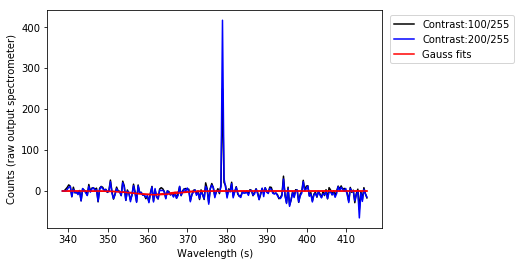

In [10]:
plot_low_int = 20
plt.plot(wavelengths[start_points_uv:end_points_uv],spectra_uv[plot_low_int][start_points_uv:end_points_uv],color="k", label="Contrast:" + str((plot_low_int*step_size)) + "/255")
plt.plot(wavelengths[start_points_uv:end_points_uv],fit_spectra_uv[plot_low_int][start_points_uv:end_points_uv],color="r")
plot_high_int = 40
plt.plot(wavelengths[start_points_uv:end_points_uv],spectra_uv[plot_high_int][start_points_uv:end_points_uv],color="b", label="Contrast:" + str((plot_high_int*step_size)) + "/255")
plt.plot(wavelengths[start_points_uv:end_points_uv],fit_spectra_uv[plot_high_int][start_points_uv:end_points_uv],color="r", label="Gauss fits")
plt.xlabel("Wavelength (s)")
plt.ylabel("Counts (raw output spectrometer)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

Plot intensities in µW versus contrast.

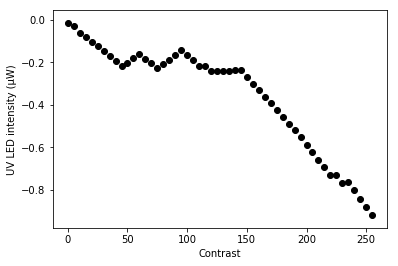

In [11]:
plt.scatter(contrasts, intensities_uv,color="k")
plt.xlabel("Contrast")
plt.ylabel("UV LED intensity (µW)")

#### Transform output of spectra into µW and get intensities vs contrast curve (green LED)
Use raw spectra to transform into µW.

In [25]:
start_points_green = 550
end_points_green = 750
led_peak_green = 576

spectra_green_µw = list()
intensities_green = list()

for iS in range(n_steps):
    current_spectrum = spectra_green[iS][start_points_green:end_points_green]
    current_spectrum = np.array(current_spectrum,dtype=float)
    current_spectrum_µw = np.multiply(current_spectrum,calib_values[start_points_green:end_points_green])/int_time_s
    spectra_green_µw.append(current_spectrum_µw)
    intensities_green.append(np.sum(spectra_green_µw))
    
intensities_uv = intensities_green

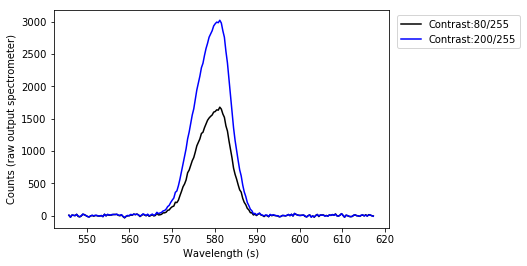

In [26]:
plot_low_int = 16
plt.plot(wavelengths[start_points_green:end_points_green],spectra_green[plot_low_int][start_points_green:end_points_green],color="k", label="Contrast:" + str((plot_low_int*step_size)) + "/255")
plot_high_int = 40
plt.plot(wavelengths[start_points_green:end_points_green],spectra_green[plot_high_int][start_points_green:end_points_green],color="b", label="Contrast:" + str((plot_high_int*step_size)) + "/255")
plt.xlabel("Wavelength (s)")
plt.ylabel("Counts (raw output spectrometer)")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

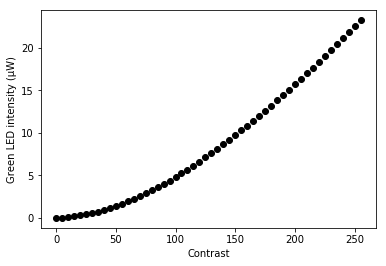

In [27]:
plt.scatter(contrasts, intensities_green,color="k")
plt.xlabel("Contrast")
plt.ylabel("Green LED intensity (µW)")

#### Calculate correction table for UV LED

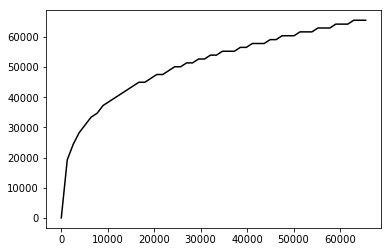

In [20]:
LUT = np.copy(contrasts)
rate = np.copy(intensities_uv)
line = [min(rate) +i/len(rate)*max(rate) for i in range(len(rate))]
rate_lin = np.copy(rate)

for iLev in range(n_steps):    
    iCorrLev = np.where(rate>=line[iLev])[0][0]
    LUT[iLev] = contrasts[iCorrLev]
    rate_lin[iLev] = rate[iCorrLev]

levels_interp = np.array([i for i in range(256)])
temp          = np.interp(levels_interp, contrasts, LUT)
LUT_interp    = [int(v/255.0* (pow(2,16)-1)) for v in temp]
levels_interp = [int(v/255.0* (pow(2,16)-1)) for v in levels_interp]

LUT_UV = np.copy(LUT_interp)

plt.plot(levels_interp,LUT_interp,color="k")

#### Calculate correction table for UV LED

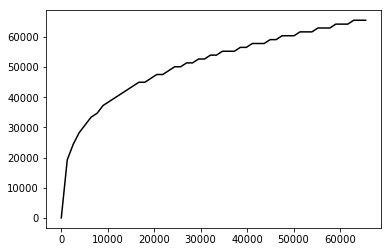

In [21]:
LUT = np.copy(contrasts)
rate = np.copy(intensities_green)
line = [min(rate) +i/len(rate)*max(rate) for i in range(len(rate))]
rate_lin = np.copy(rate)

for iLev in range(n_steps):    
    iCorrLev = np.where(rate>=line[iLev])[0][0]
    LUT[iLev] = contrasts[iCorrLev]
    rate_lin[iLev] = rate[iCorrLev]

levels_interp = np.array([i for i in range(256)])
temp          = np.interp(levels_interp, contrasts, LUT)
LUT_interp    = [int(v/255.0* (pow(2,16)-1)) for v in temp]
levels_interp = [int(v/255.0* (pow(2,16)-1)) for v in levels_interp]

LUT_Green = np.copy(LUT_interp)

plt.plot(levels_interp,LUT_interp,color="k")

#### Generate gamma table

In [22]:
results = []
results.append(np.array([int(v+1)*256-1 for v in range(256)]))
results.append(LUT_Green)
results.append(LUT_UV)

txtFileNewLineStr = "\r\n"
GammaFileName = "defaultGammaLUT"
#np.savetxt(filePath + GammaFileName, np.transpose(results))
np.savetxt(filePath + GammaFileName+".txt", np.transpose(results), fmt="%d", delimiter=', ', newline=txtFileNewLineStr)